# 1 TensorBoard
TensorFlow 可用于训练大规模深度神经网络所需的计算，使用该工具涉及的计算往往复杂而深奥。为了更方便 TensorFlow 程序的理解、调试与优化，谷歌发布了一套名为 TensorBoard 的可视化工具。您可以用 TensorBoard 来展现 TensorFlow 图，绘制图像生成的定量指标图以及显示附加数据（如其中传递的图像）。

## 1.1 启动TensorBoard
1. 登陆虚拟机，以下命令均在虚拟机内执行
2. 停止并删除当前实验环境
```
docker stop datalab
docker rm datalab
```
3. 重新启动datalab,相比较以前的命令而言，增加了一个新的端口映射6006。
```
docker run -itd -p "0.0.0.0:8081:8080" -p "0.0.0.0:6006:6006" -v "${HOME}:/content" \
    --restart=always --name=datalab  \
    registry.cn-hangzhou.aliyuncs.com/oedu/datalab:local-20180214
```
4. 进入datalab容器shell环境，并启动TensorBoard (**后续每次要运行TensorBoard都需要执行该步骤**)
```
docker exec -it datalab /bin/sh
tensorboard -logdir /content
```
5. 在虚拟机软件中添加端口映射，将主机6007端口映射到虚拟机的6006端口

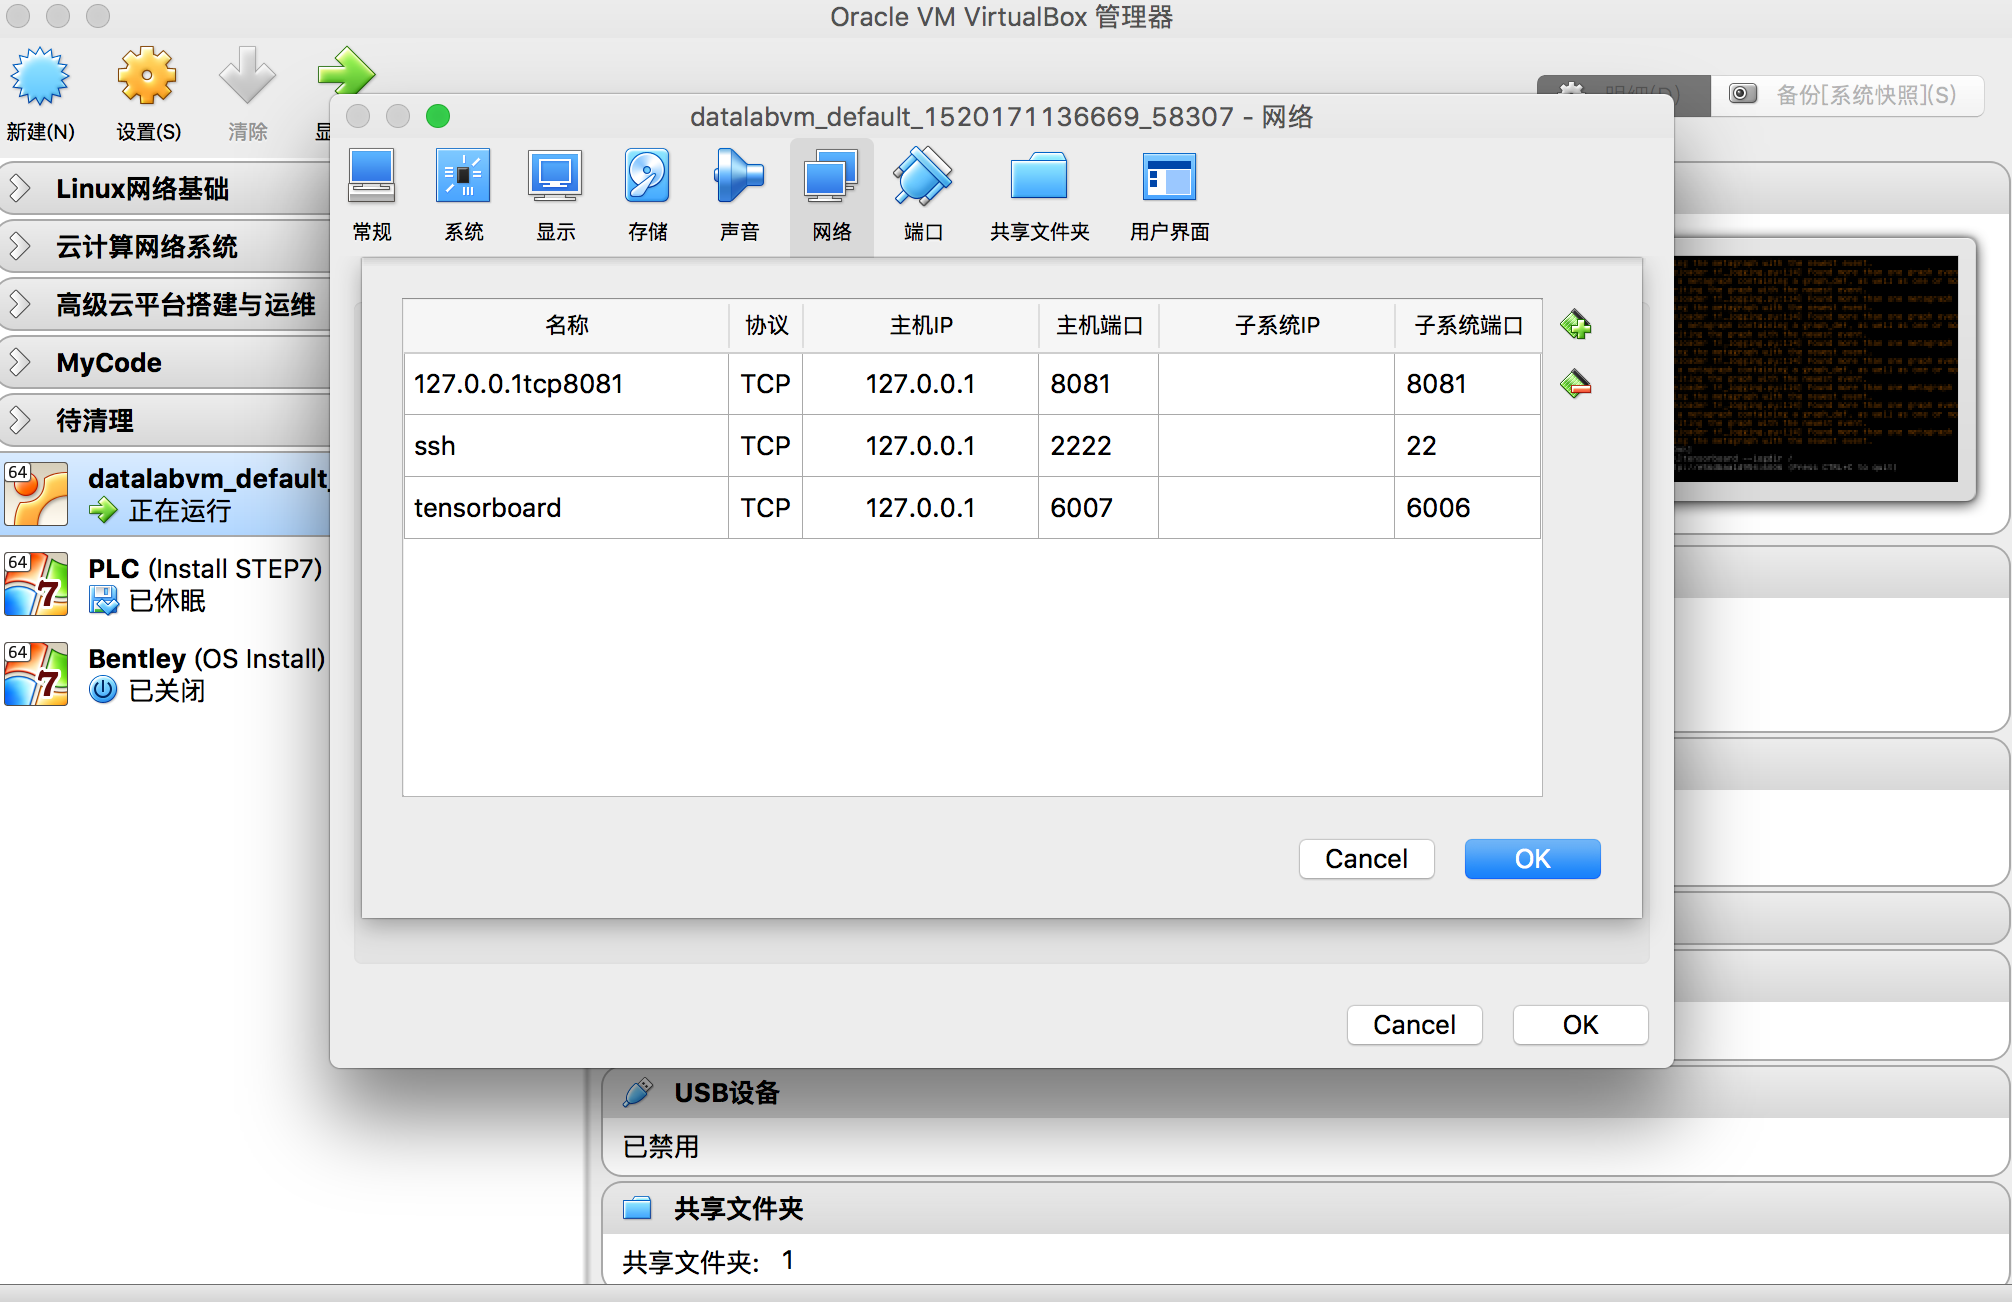

设置完毕后，在浏览器可以访问tensorboard，效果如下图所示：
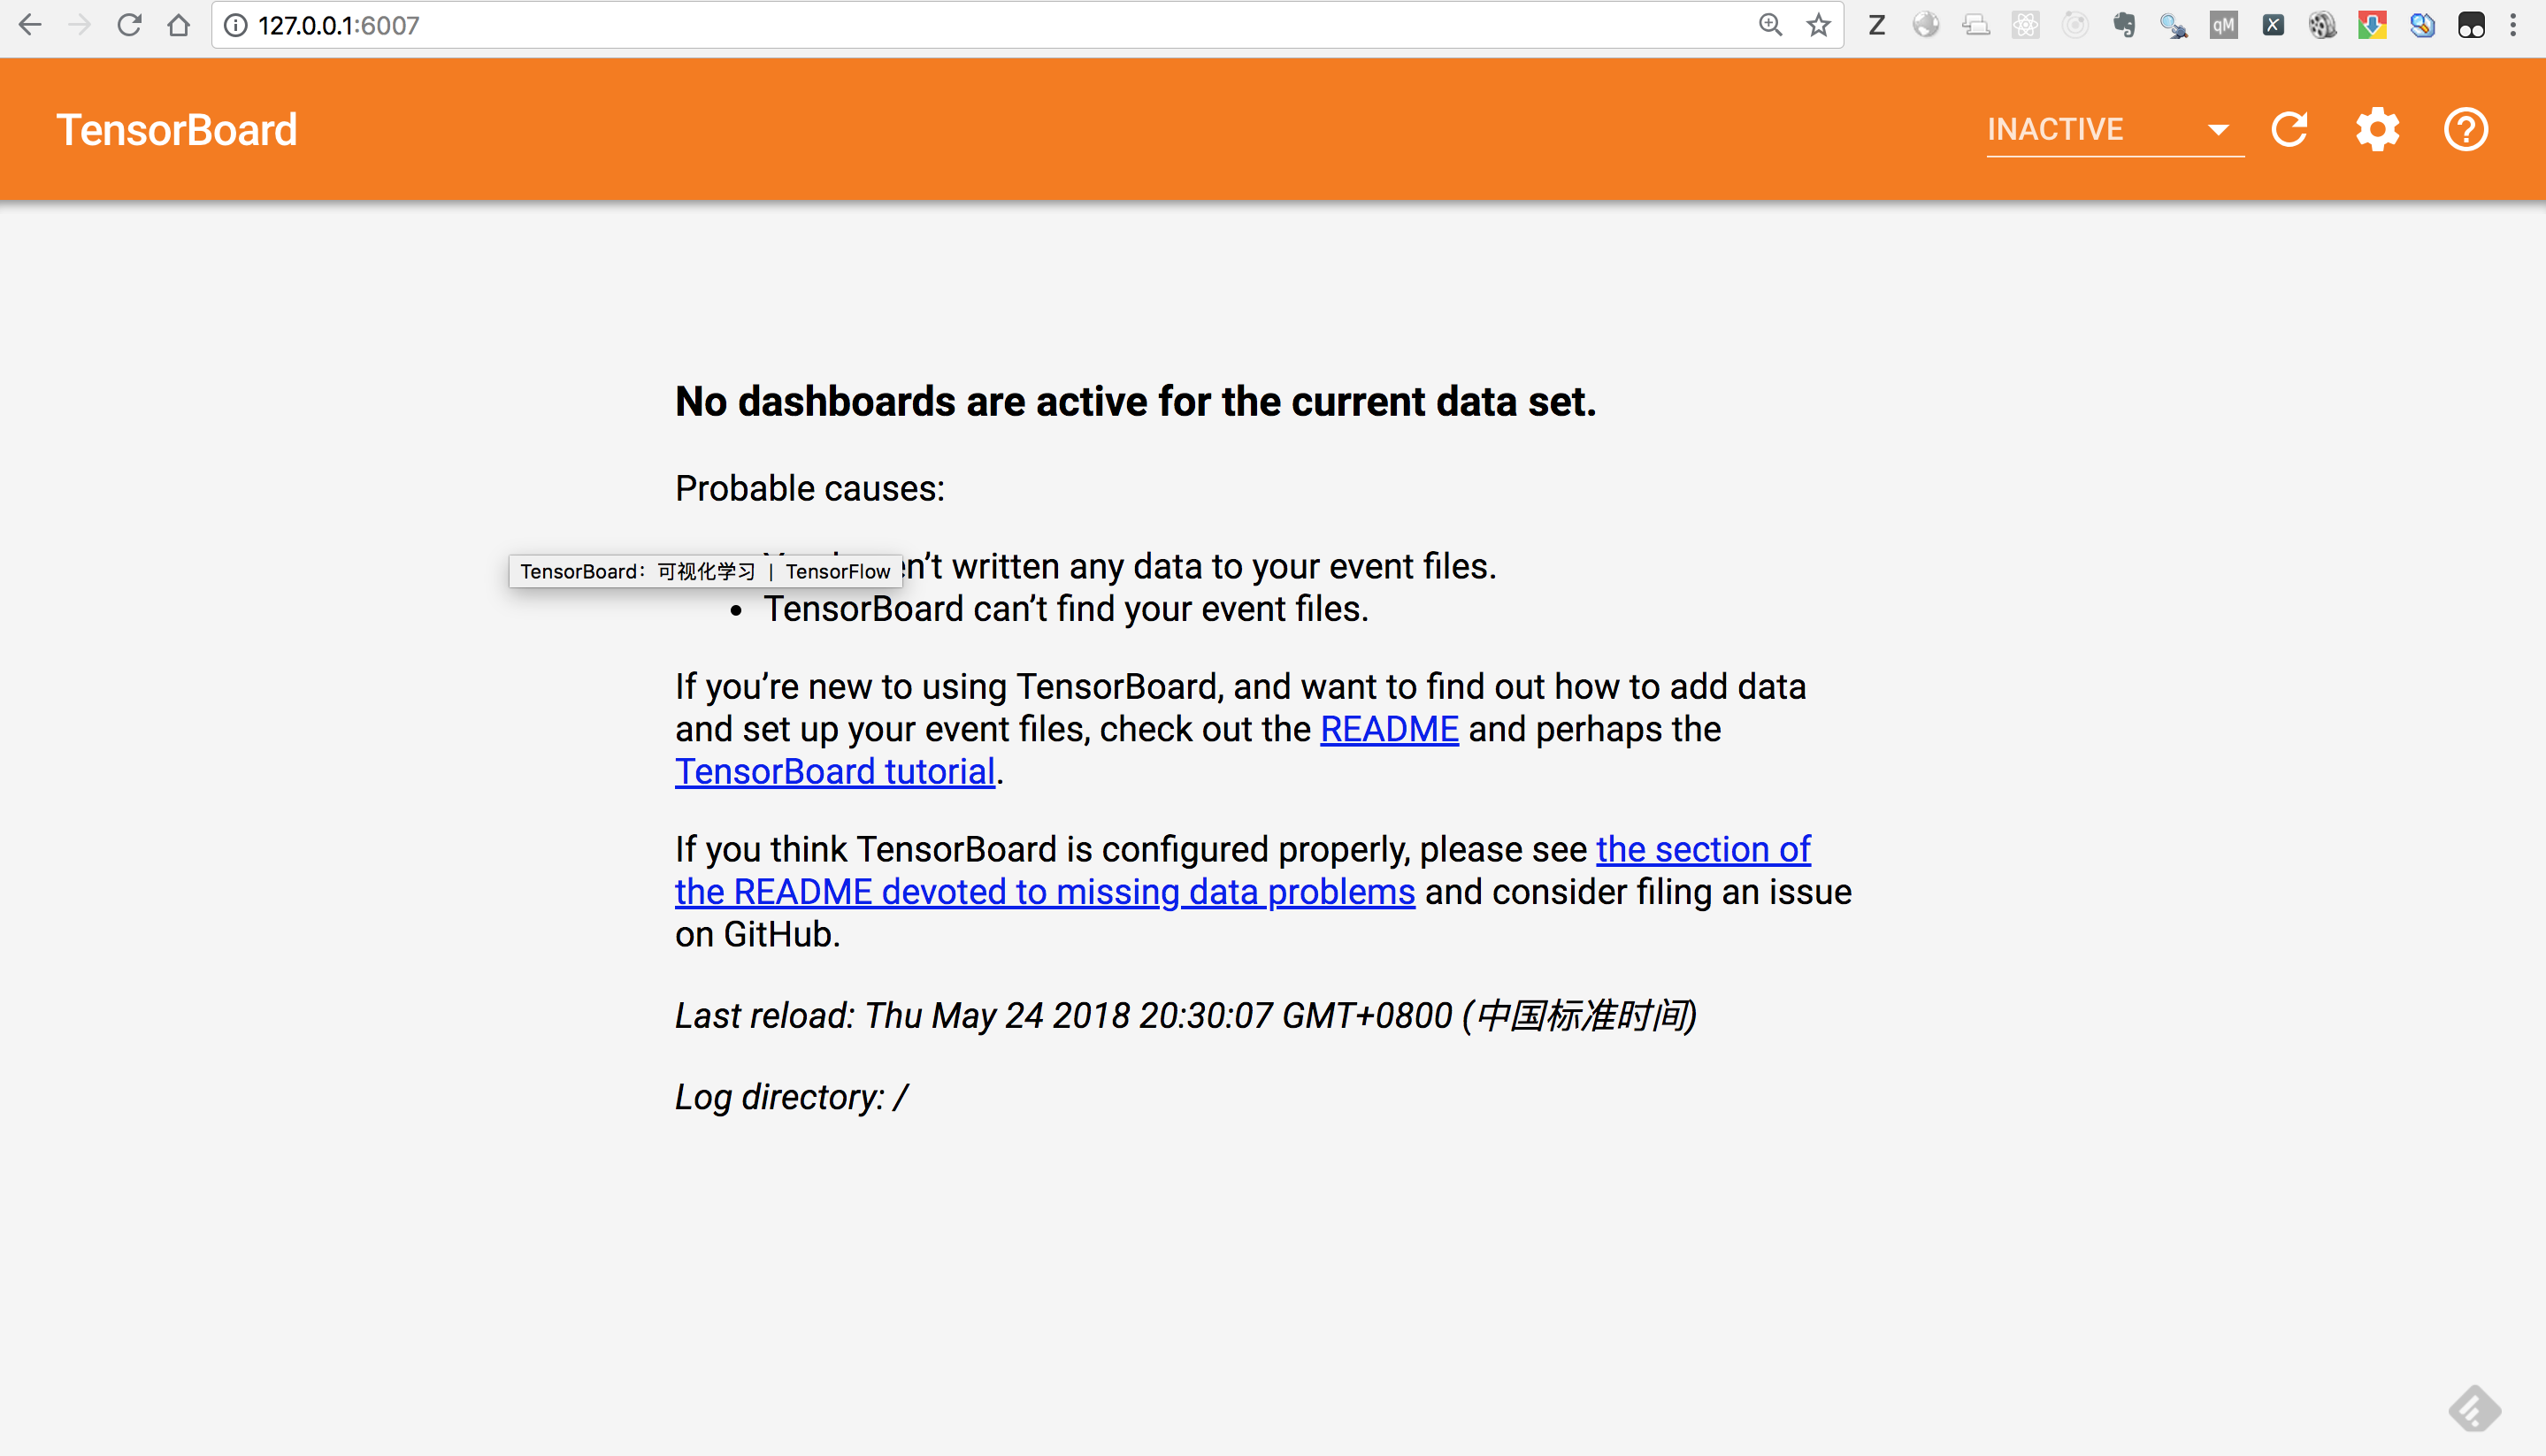

## 1.2 小试牛刀

In [6]:
import tensorflow as tf

def add_layer(inputs, in_size, out_size, activation_function=None):
    # add one more layer and return the output of this layer
    Weights = tf.Variable(tf.random_normal([in_size, out_size]), name='W')
    biases = tf.Variable(tf.zeros([1, out_size]) + 0.1, name='b')
    Wx_plus_b = tf.add(tf.matmul(inputs, Weights), biases)
    if activation_function is None:
        outputs = Wx_plus_b
    else:
        outputs = activation_function(Wx_plus_b, )
    
    return outputs


# define placeholder for inputs to network
xs = tf.placeholder(tf.float32, [None, 1], name='x_input')
ys = tf.placeholder(tf.float32, [None, 1], name='y_input')

# add hidden layer
l1 = add_layer(xs, 1, 10, activation_function=tf.nn.relu)

# add output layer
prediction = add_layer(l1, 10, 1, activation_function=None)

# the error between prediciton and real data
loss = tf.reduce_mean(tf.reduce_sum(tf.square(ys - prediction),
                                        reduction_indices=[1]))

train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

with tf.Session() as sess:
    # 将当前会话中的计算图保存
    writer = tf.summary.FileWriter("logs/", sess.graph)

    init = tf.global_variables_initializer()
    sess.run(init)

运行上述代码，通过浏览器访问http://localhost:6007 
可以发现TensorBoard中显示了我们代码对应的计算图，以及计算图中的节点。
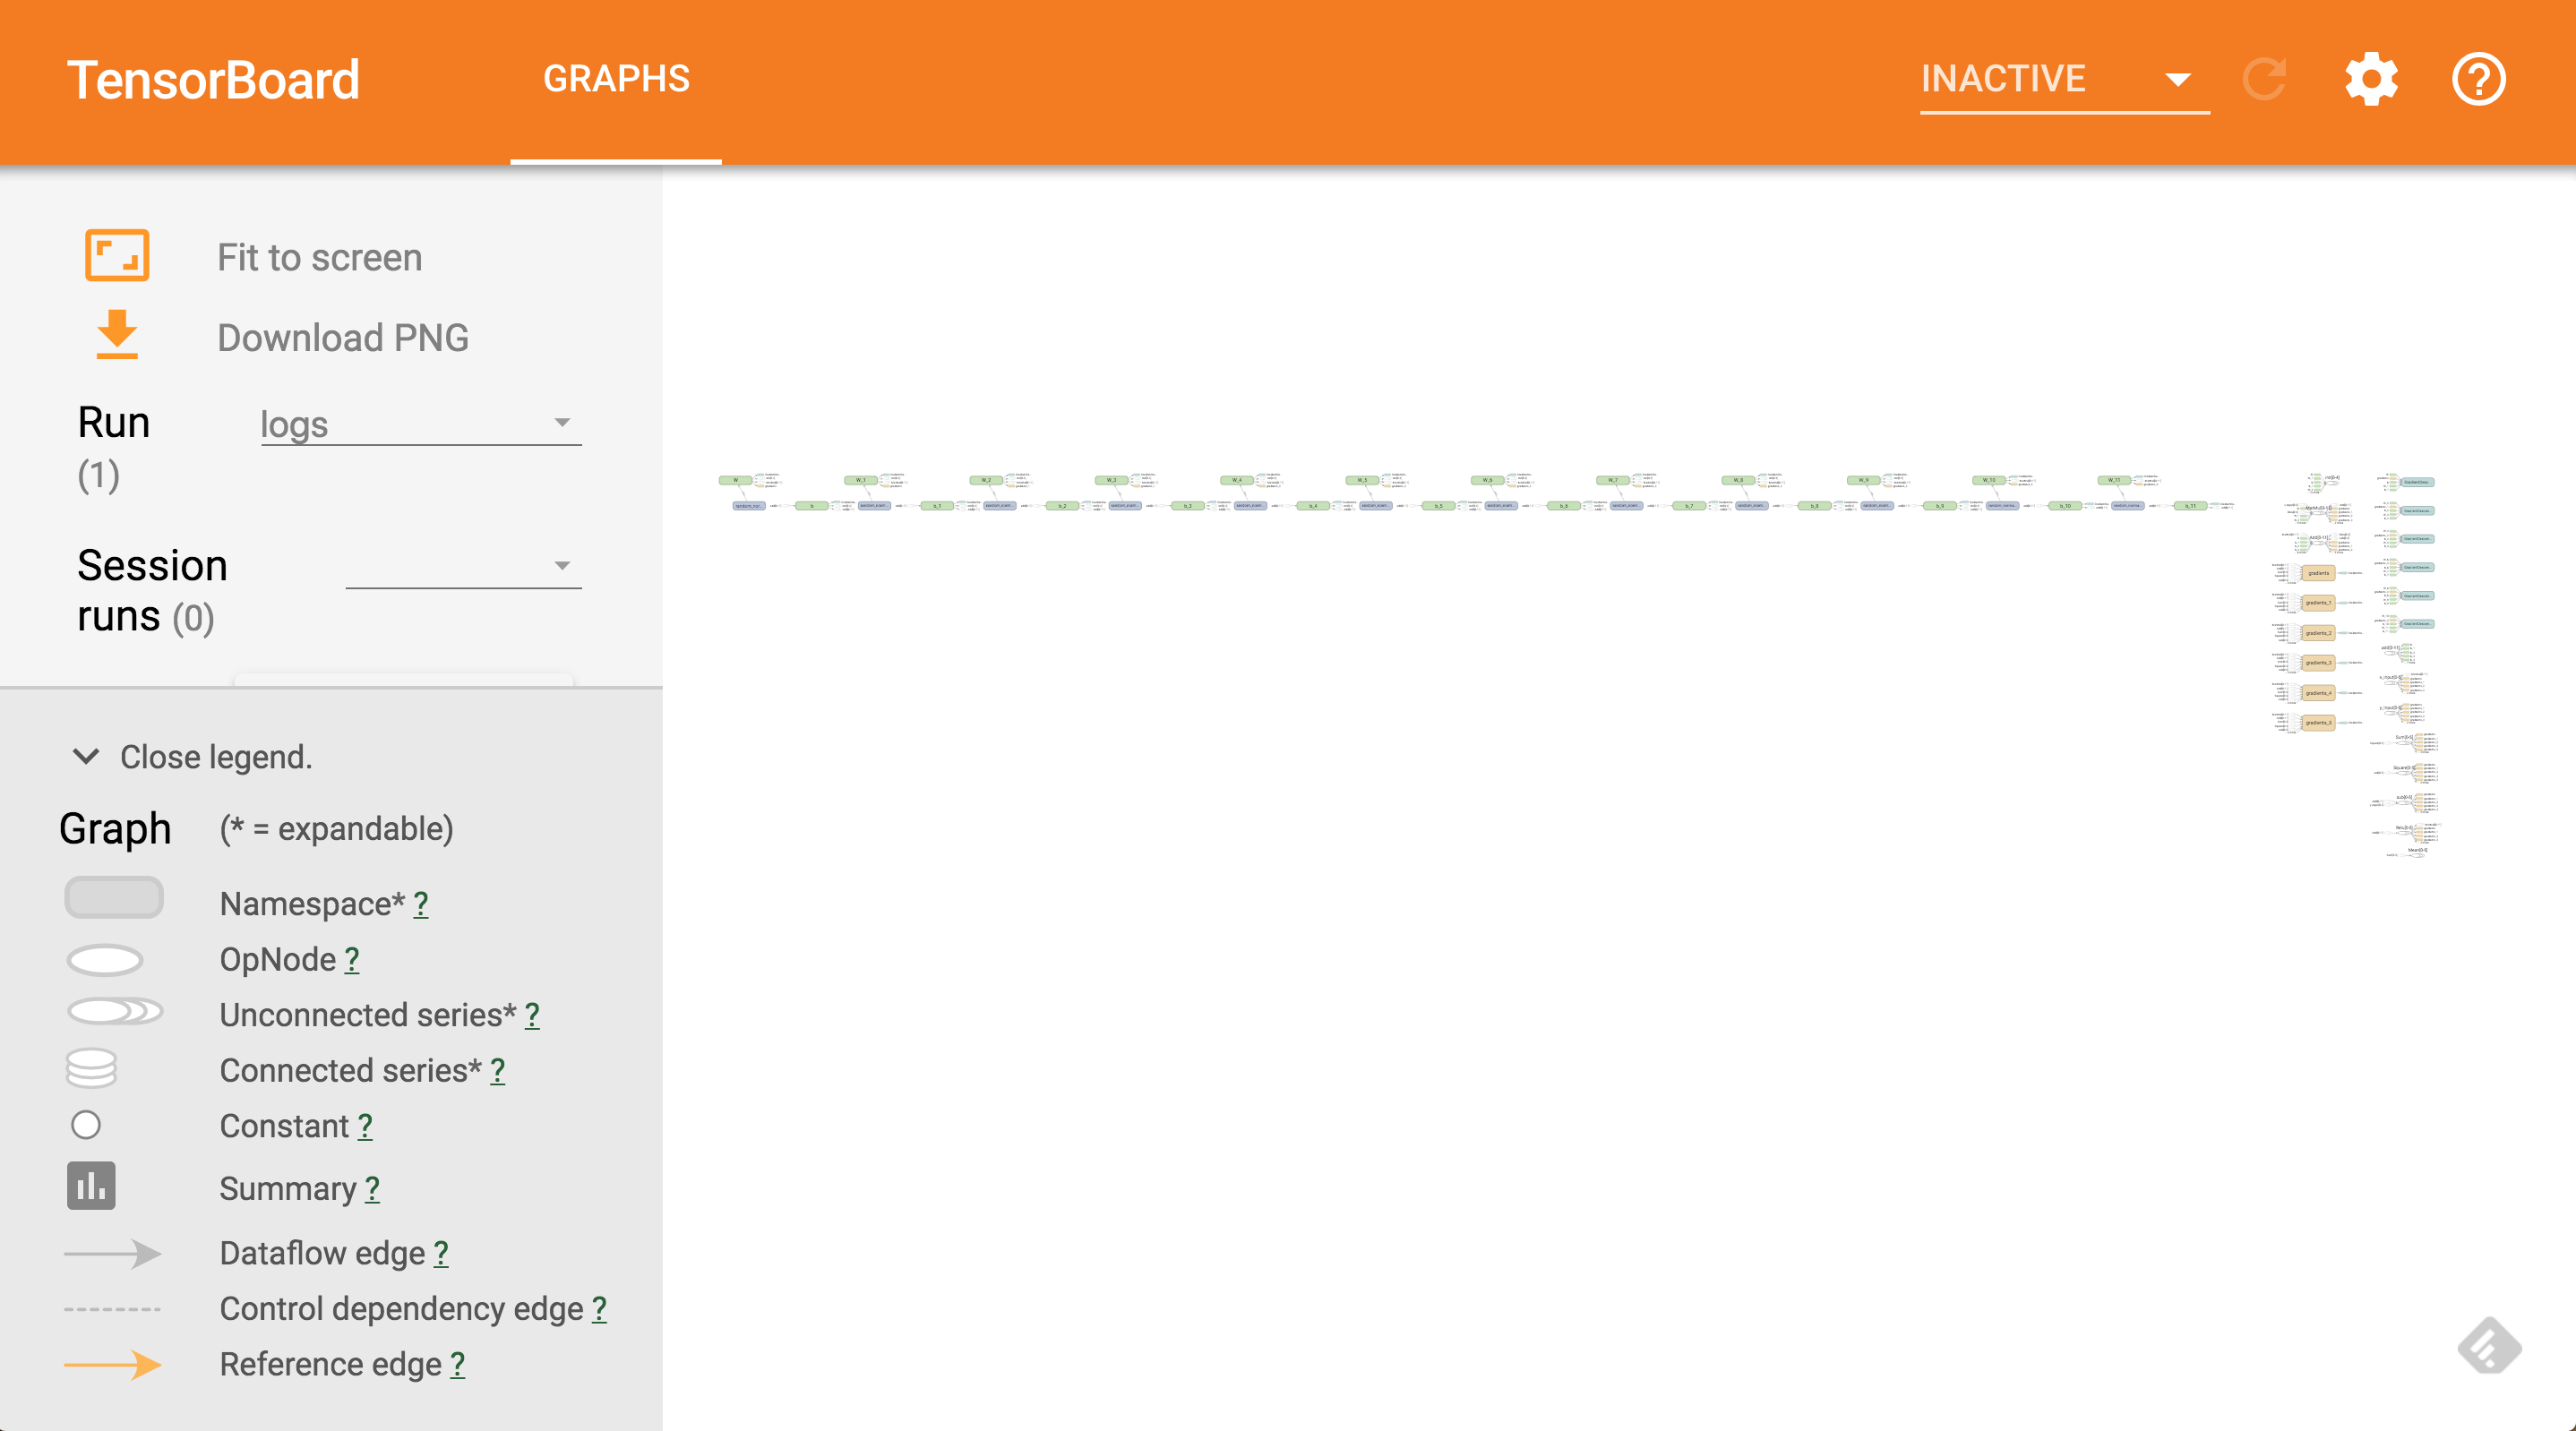

## 1.3 变量命名空间

In [7]:
a = tf.Variable(tf.zeros([10]), name='a')
print(a)

with tf.name_scope('test'):
    a1 = tf.Variable(tf.zeros([10]), name='a')

print(a1)

<tf.Variable 'a:0' shape=(10,) dtype=float32_ref>
<tf.Variable 'test/a:0' shape=(10,) dtype=float32_ref>


使用命名空间不仅可以更好的管理变量，还可以优化TensorBoard的显示：
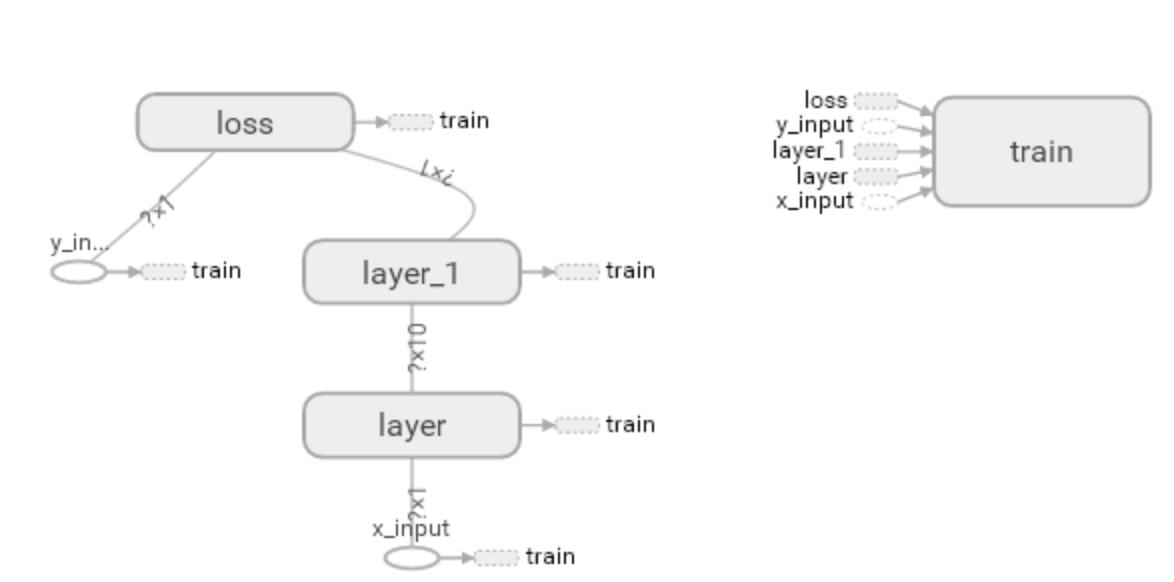

练习：将1.2中的代码对应的变量放入指定的命名空间，具体要求如下(粗体为变量名，其他为命名空间名字，缩进代表命名空间层次)：

- layer
    - weights
        - **Weights**
    - biases
        - **biases**
    - Wx_plus_b
        - **Wx_plus_b**

- inputs
    - **xs**
    - **ys**
    
- loss
    - **loss**
    
- train
    - **train_step**
    
运行成功后，在TensorBoard中看到的结果如下图所示：
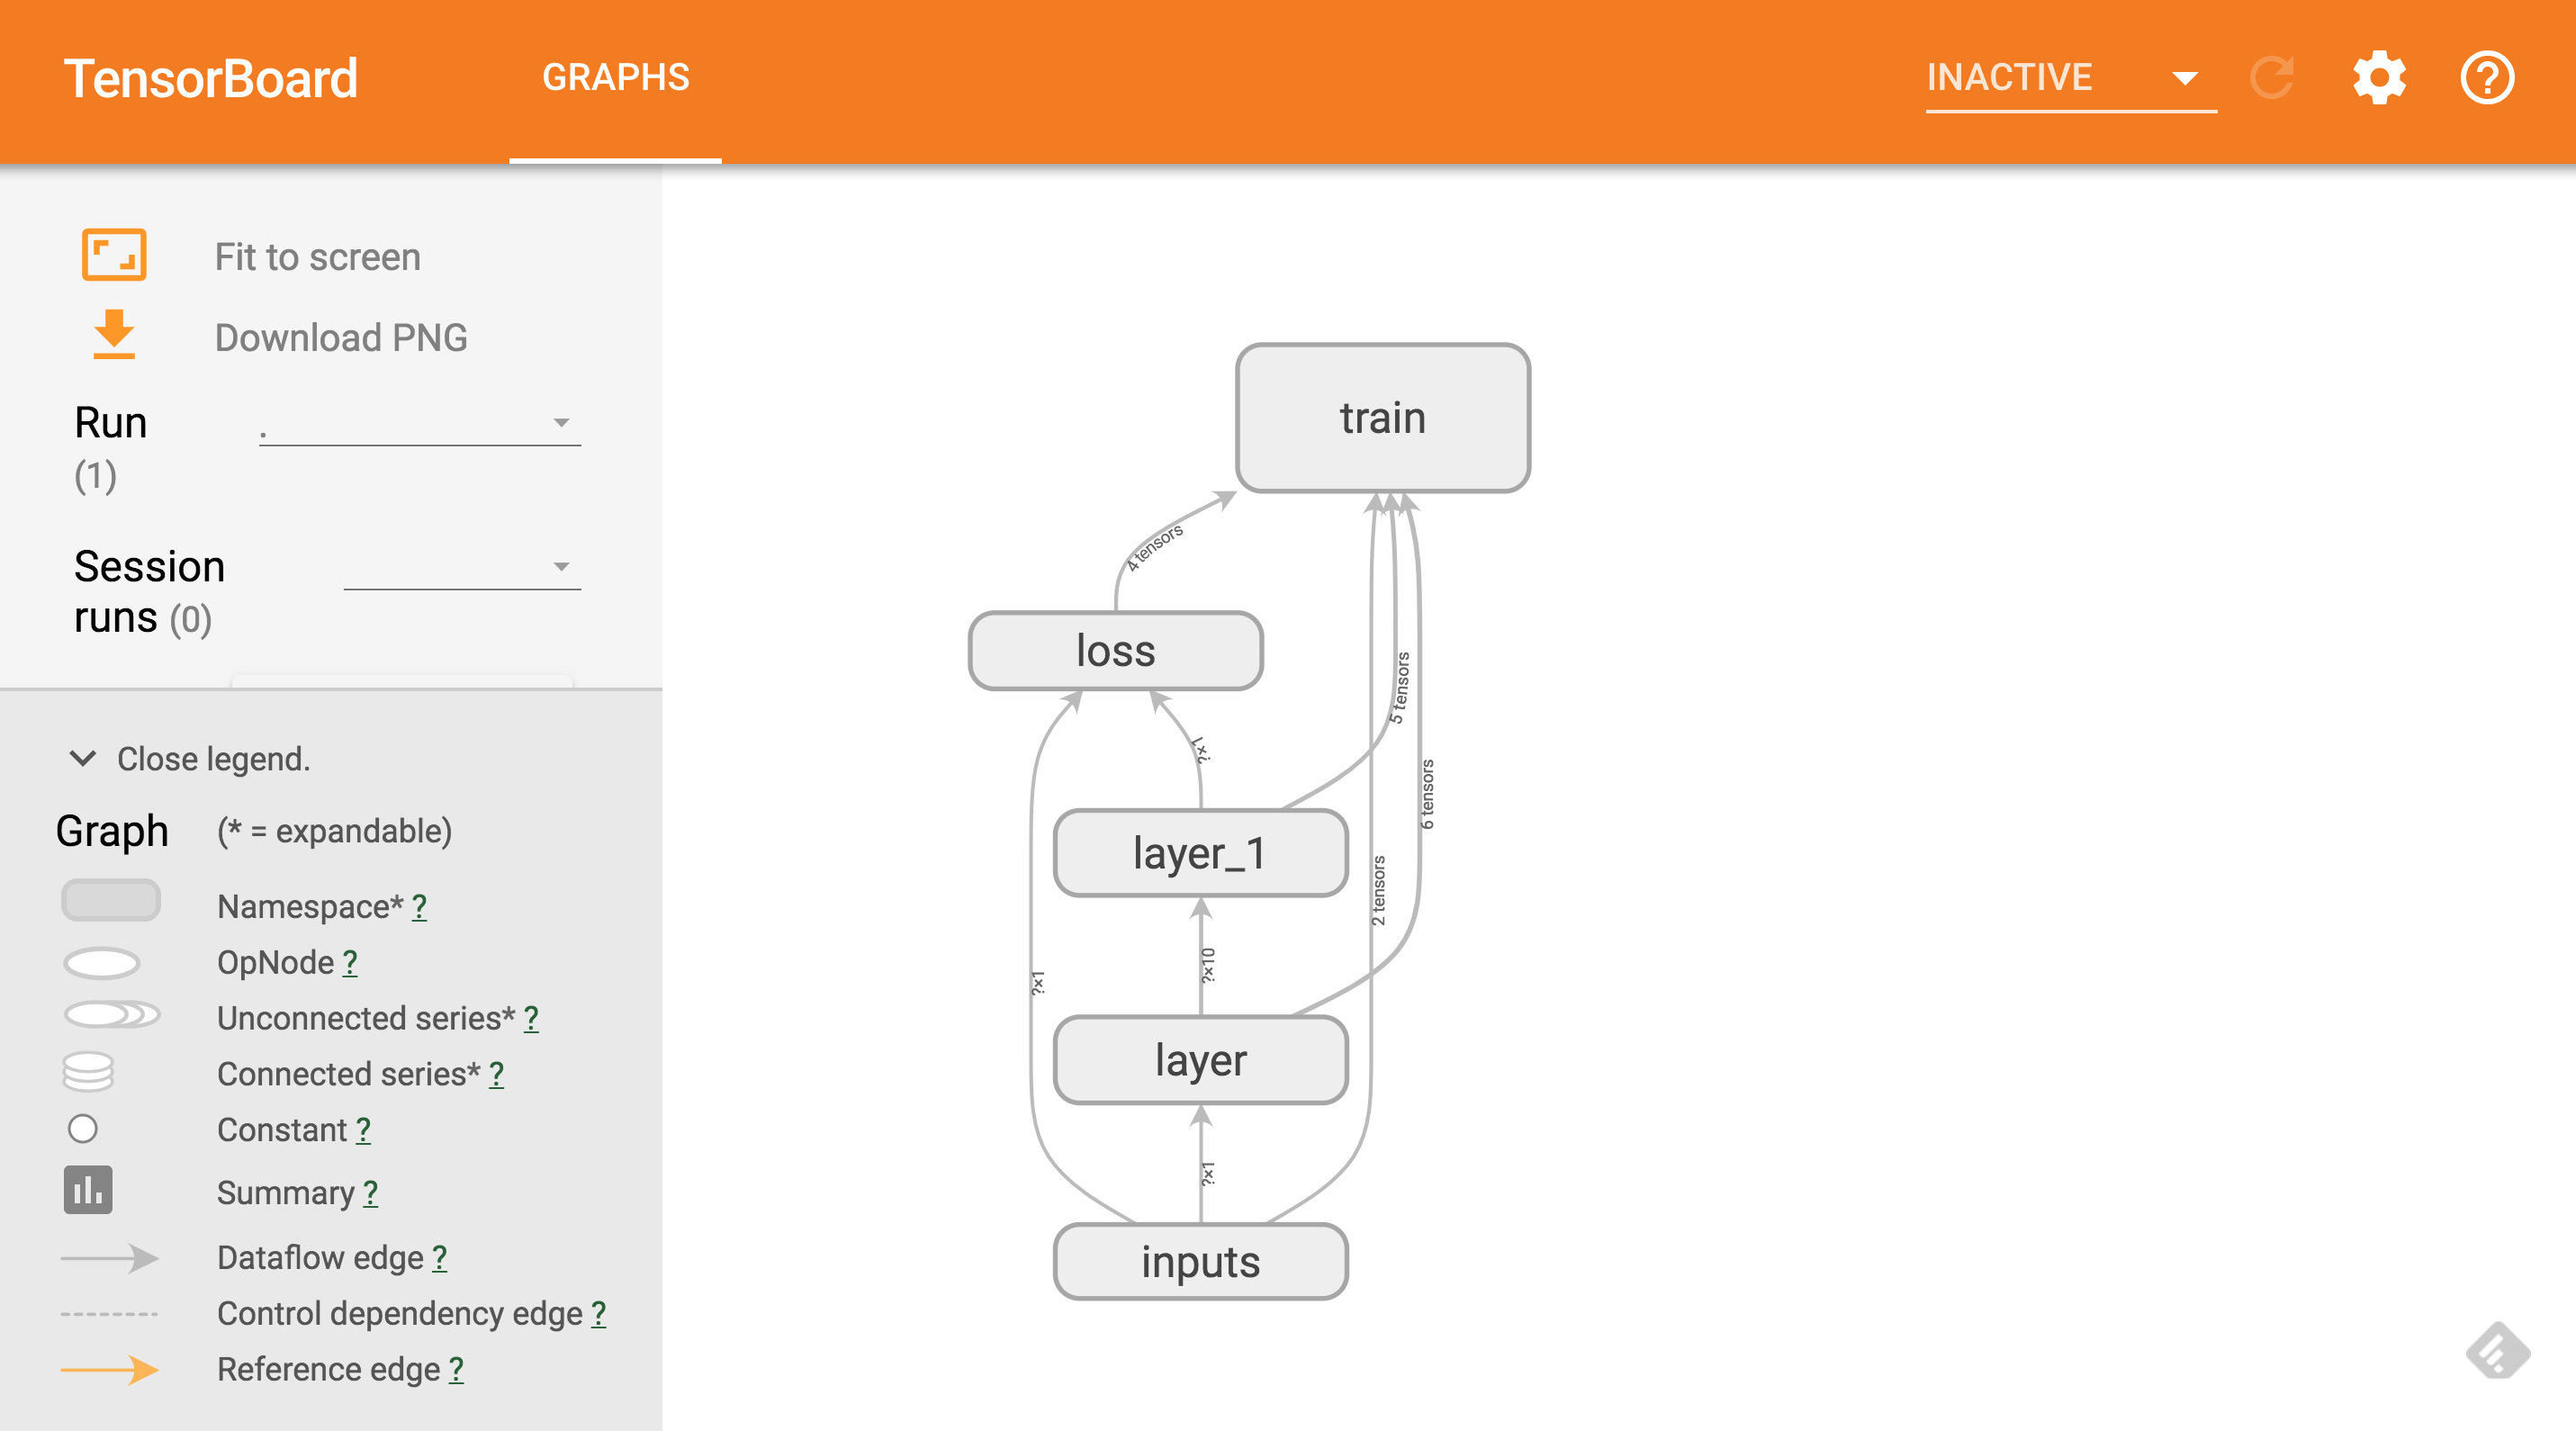

In [2]:
import tensorflow as tf

def add_layer(inputs, in_size, out_size, activation_function=None):
    # add one more layer and return the output of this layer
    with tf.name_scope('layer'):
        with tf.name_scope('weights'):
            Weights = tf.Variable(tf.random_normal([in_size, out_size]), name='W')
            
        with tf.name_scope('biases'):
            biases = tf.Variable(tf.zeros([1, out_size]) + 0.1, name='b')
            
        with tf.name_scope('Wx_plus_b'):
            Wx_plus_b = tf.add(tf.matmul(inputs, Weights), biases)
            
        if activation_function is None:
            outputs = Wx_plus_b
        else:
            outputs = activation_function(Wx_plus_b, )
    
    return outputs


with tf.name_scope('inputs'):
    # define placeholder for inputs to network
    xs = tf.placeholder(tf.float32, [None, 1], name='x_input')
    ys = tf.placeholder(tf.float32, [None, 1], name='y_input')

# add hidden layer
l1 = add_layer(xs, 1, 10, activation_function=tf.nn.relu)

# add output layer
prediction = add_layer(l1, 10, 1, activation_function=None)

# the error between prediciton and real data
with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.reduce_sum(tf.square(ys - prediction),
                                        reduction_indices=[1]))
with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

with tf.Session() as sess:
    # 将当前会话中的计算图保存
    writer = tf.summary.FileWriter("logs/", sess.graph)

    init = tf.global_variables_initializer()
    sess.run(init)

## 1.4 计算图(tf.Graph)


**如果将1.3中的代码执行多遍，刷新TensorBoard界面，你可能会看到这样的显示，为什么呢？**
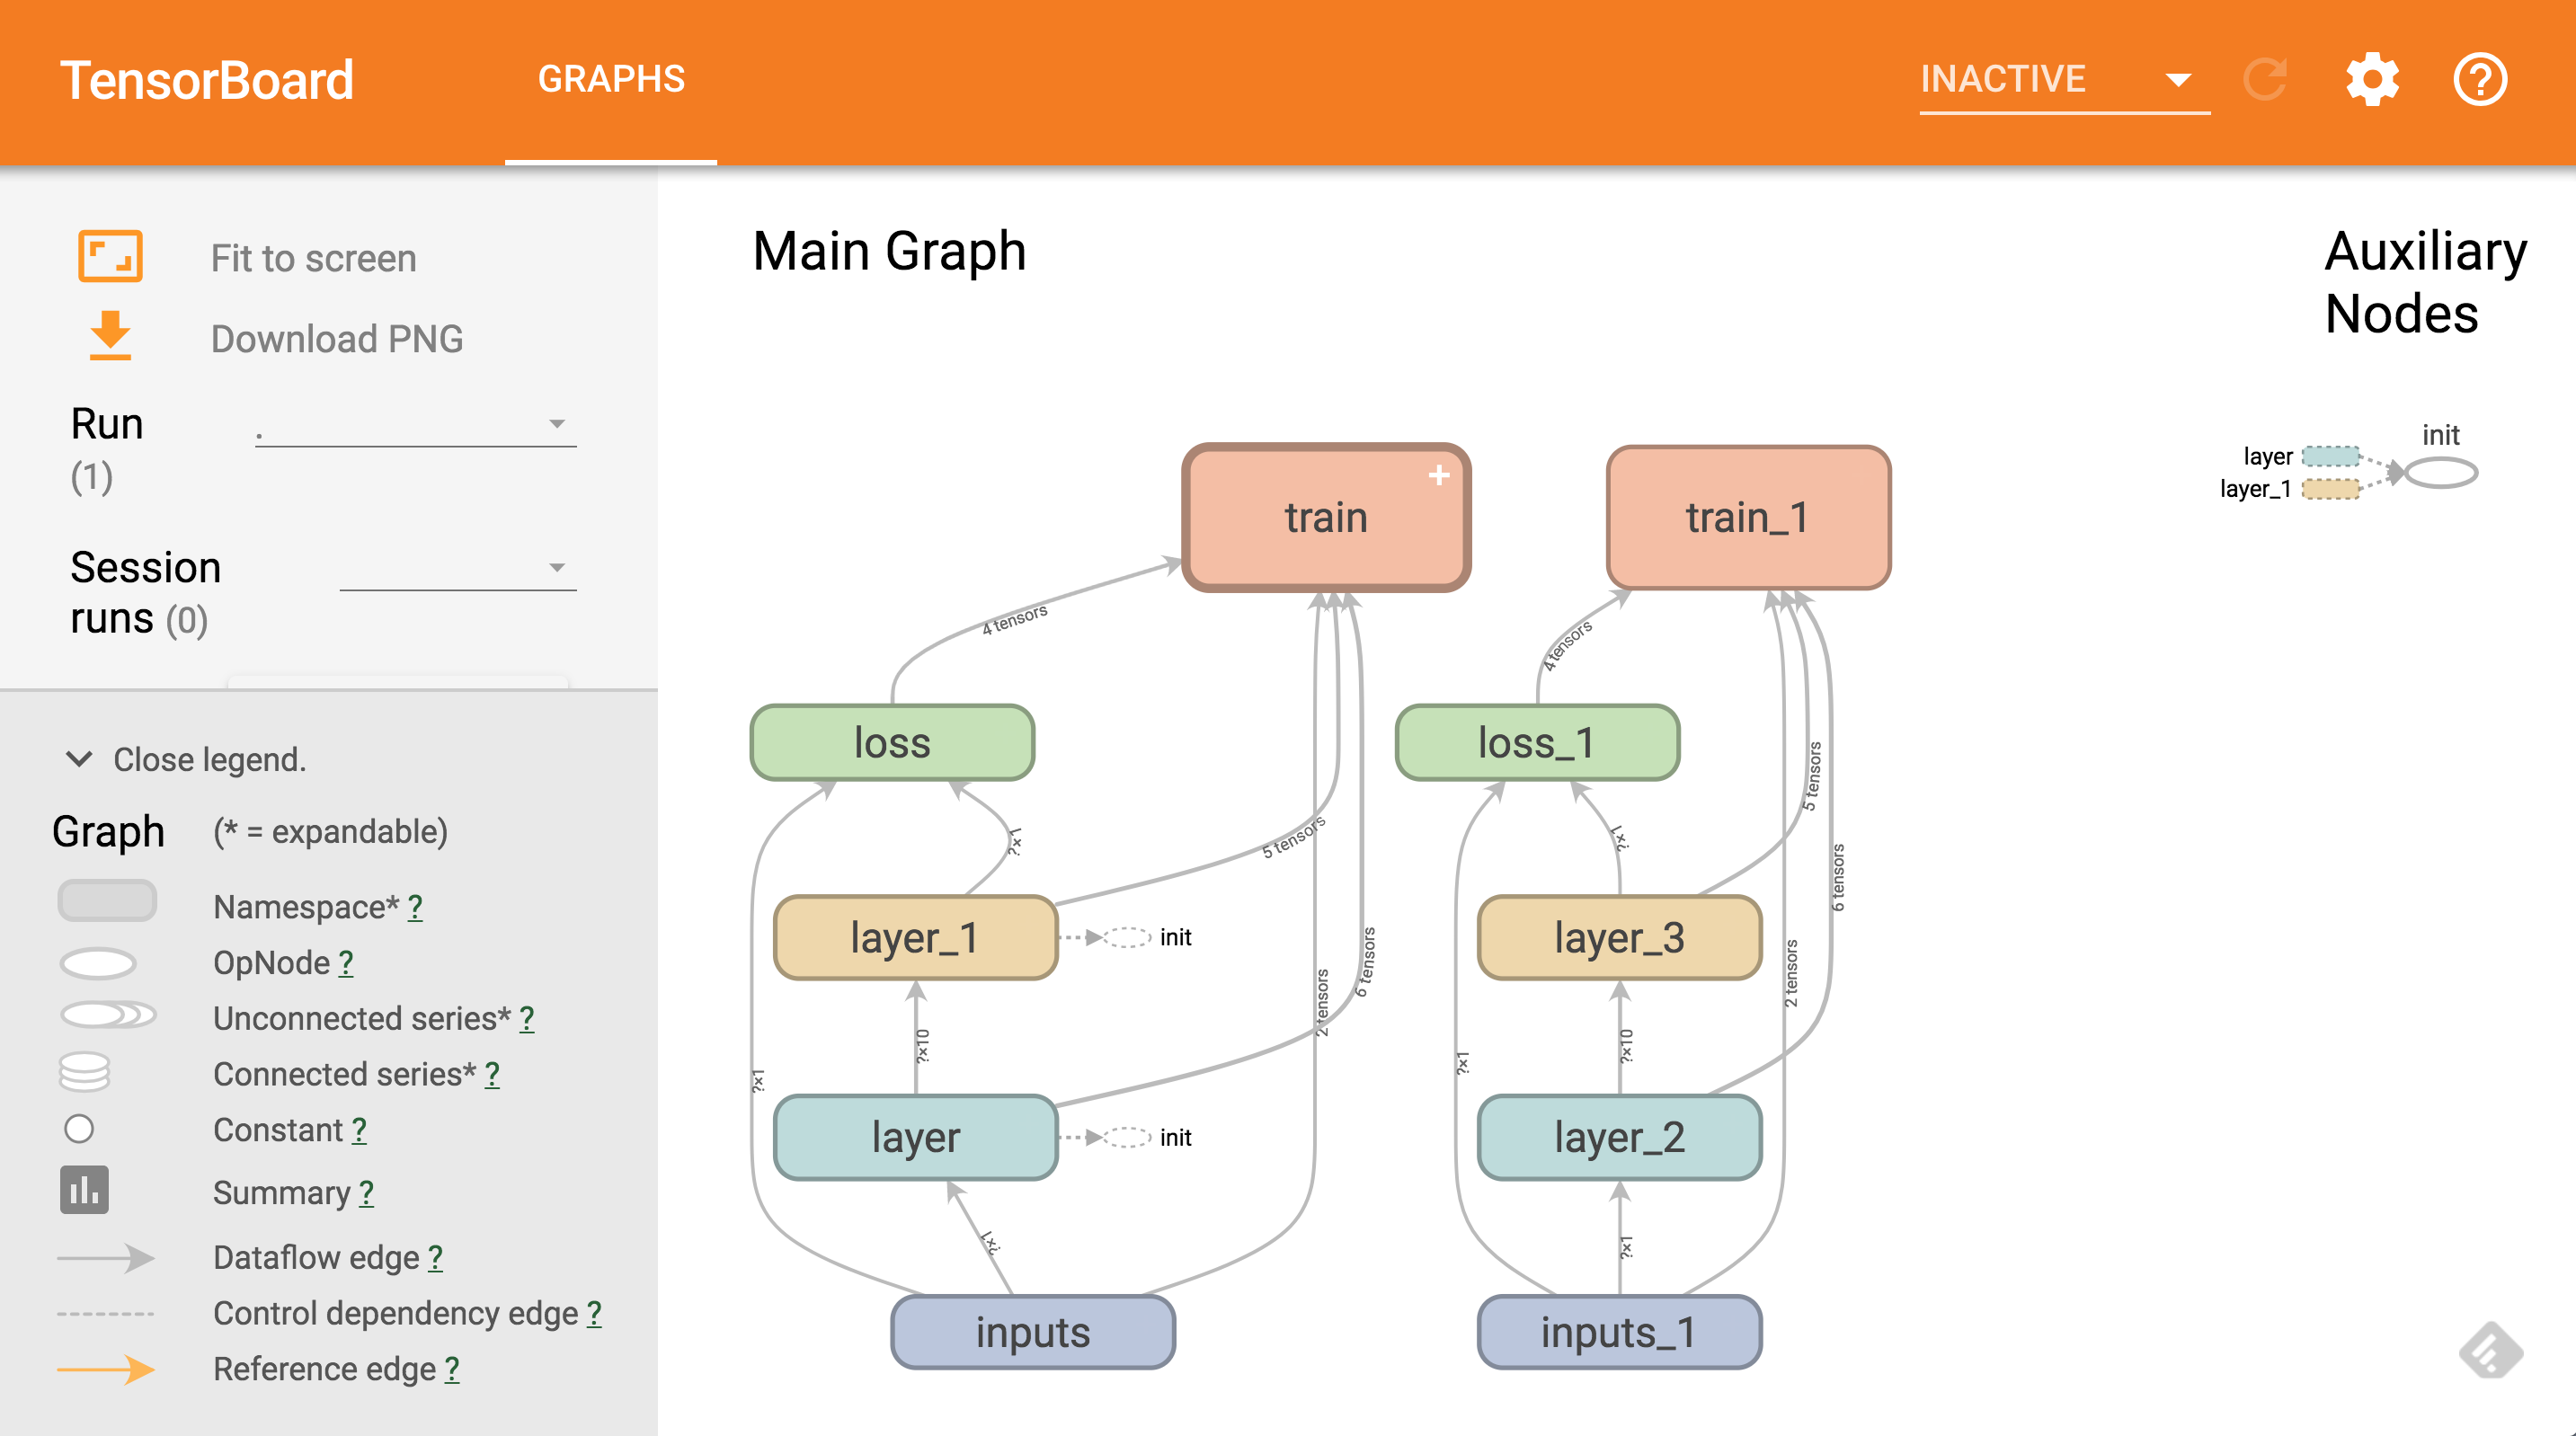

计算图是排列成一个图的一系列 TensorFlow 指令。图由两种类型的对象组成。
- 指令（或“op"）：图的节点。 指令说明的是消耗和生成张量的计算。
- 张量：图的边。它们代表将流经图的值。大多数 TensorFlow 函数会返回 tf.Tensors。

![计算图](https://www.safaribooksonline.com/library/view/learning-tensorflow/9781491978504/assets/letf_0304.png)



关于计算图的详细介绍，请参考：https://www.tensorflow.org/programmers_guide/graphs?hl=zh-cn

In [5]:
a = tf.constant(5) 
print(a)
print(a.graph)
print(tf.get_default_graph())

with tf.Graph().as_default() as g:
    b = tf.constant(2)
    print(b)
    print(b.graph)
    print(g)
    
print(tf.get_default_graph())

Tensor("Const_2:0", shape=(), dtype=int32)
Tensor("Const:0", shape=(), dtype=int32)


练习：使用`tf.Graph()`创建一个新的计算图，将1.3的代码所有的TensorFlow节点都放入到该计算图中，多次执行相关代码后在TensorBoard不会出现多张图的情形。

In [2]:
import tensorflow as tf

def add_layer(inputs, in_size, out_size, activation_function=None):
    # add one more layer and return the output of this layer
    with tf.name_scope('layer'):
        with tf.name_scope('weights'):
            Weights = tf.Variable(tf.random_normal([in_size, out_size]), name='W')
            
        with tf.name_scope('biases'):
            biases = tf.Variable(tf.zeros([1, out_size]) + 0.1, name='b')
            
        with tf.name_scope('Wx_plus_b'):
            Wx_plus_b = tf.add(tf.matmul(inputs, Weights), biases)
            
        if activation_function is None:
            outputs = Wx_plus_b
        else:
            outputs = activation_function(Wx_plus_b, )
    
    return outputs


with tf.Graph().as_default() as g:
    with tf.name_scope('inputs'):
        # define placeholder for inputs to network
        xs = tf.placeholder(tf.float32, [None, 1], name='x_input')
        ys = tf.placeholder(tf.float32, [None, 1], name='y_input')

    # add hidden layer
    l1 = add_layer(xs, 1, 10, activation_function=tf.nn.relu)

    # add output layer
    prediction = add_layer(l1, 10, 1, activation_function=None)

    # the error between prediciton and real data
    with tf.name_scope('loss'):
        loss = tf.reduce_mean(tf.reduce_sum(tf.square(ys - prediction),
                                            reduction_indices=[1]))
    with tf.name_scope('train'):
        train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

    with tf.Session() as sess:
        # 将当前会话中的计算图保存
        writer = tf.summary.FileWriter("logs/", sess.graph)

        init = tf.global_variables_initializer()
        sess.run(init)

# 2. FFNN

In [3]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# 导入数据
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

# 构建计算图
sess = tf.InteractiveSession()

X = tf.placeholder(tf.float32, [None, 784], name="X")

# L1：200个神经元
W1 = tf.Variable(tf.truncated_normal([784, 200], stddev=0.1))
B1 = tf.Variable(tf.zeros([200]))
Y1 = tf.nn.sigmoid(tf.matmul(X, W1)+B1)

# L2：100个神经元
W2 = tf.Variable(tf.truncated_normal([200, 100], stddev=0.1))
B2 = tf.Variable(tf.zeros([100]))
Y2 = tf.nn.sigmoid(tf.matmul(Y1, W2)+B2)

# L3: 60个神经元
W3 = tf.Variable(tf.truncated_normal([100, 60], stddev=0.1))
B3 = tf.Variable(tf.zeros([60]))
Y3 = tf.nn.sigmoid(tf.matmul(Y2, W3)+B3)

# L4: 30个神经元
W4 = tf.Variable(tf.truncated_normal([60, 30], stddev=0.1))
B4 = tf.Variable(tf.zeros([30]))
Y4 = tf.nn.sigmoid(tf.matmul(Y3, W4)+B4)

# L5: 10个神经元
W5 = tf.Variable(tf.truncated_normal([30, 10], stddev=0.1))
B5 = tf.Variable(tf.ones([10]))
Ylogits = tf.matmul(Y4, W5) + B5

# Output
Y = tf.nn.softmax(Ylogits)

# Y_: 标签
Y_ = tf.placeholder(tf.float32, [None, 10])

# 损失函数
cross_entropy = tf.reduce_mean(-tf.reduce_sum(Y_ * tf.log(Y), reduction_indices=[1]))

# 优化算法
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)


tf.global_variables_initializer().run()

for i in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    _ = sess.run([train_step], feed_dict={X: batch_xs, Y_: batch_ys})

    if i%100 == 0:
        # 计算准确率
        correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        print(accuracy.eval({X: mnist.test.images, Y_: mnist.test.labels}))
        
sess.close()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
0.0982
0.1009
0.1135
0.1028
0.1009
0.1177
0.1965
0.1596
0.2489
0.2659


## 2.2 重构

练习：上述代码中在定义隐藏层时存在大量重复代码，
1. 请使用1.2中的`add_layer`函数重构2.1中的代码;
2. 使用命名空间，将相应的代码加入到指定的命名空间;    
3. 使用`tf.Graph()`，将所有的代码加入到新创建的计算图中；
4. 将对应的计算图输出，通过TensorBoard显示；

命名空间如下所示：
- input
    - **X**
    - **Y_**
- loss
    - **cross_entropy**
- train
    - **train**
    
TensorBoard显示结果如下图所示：
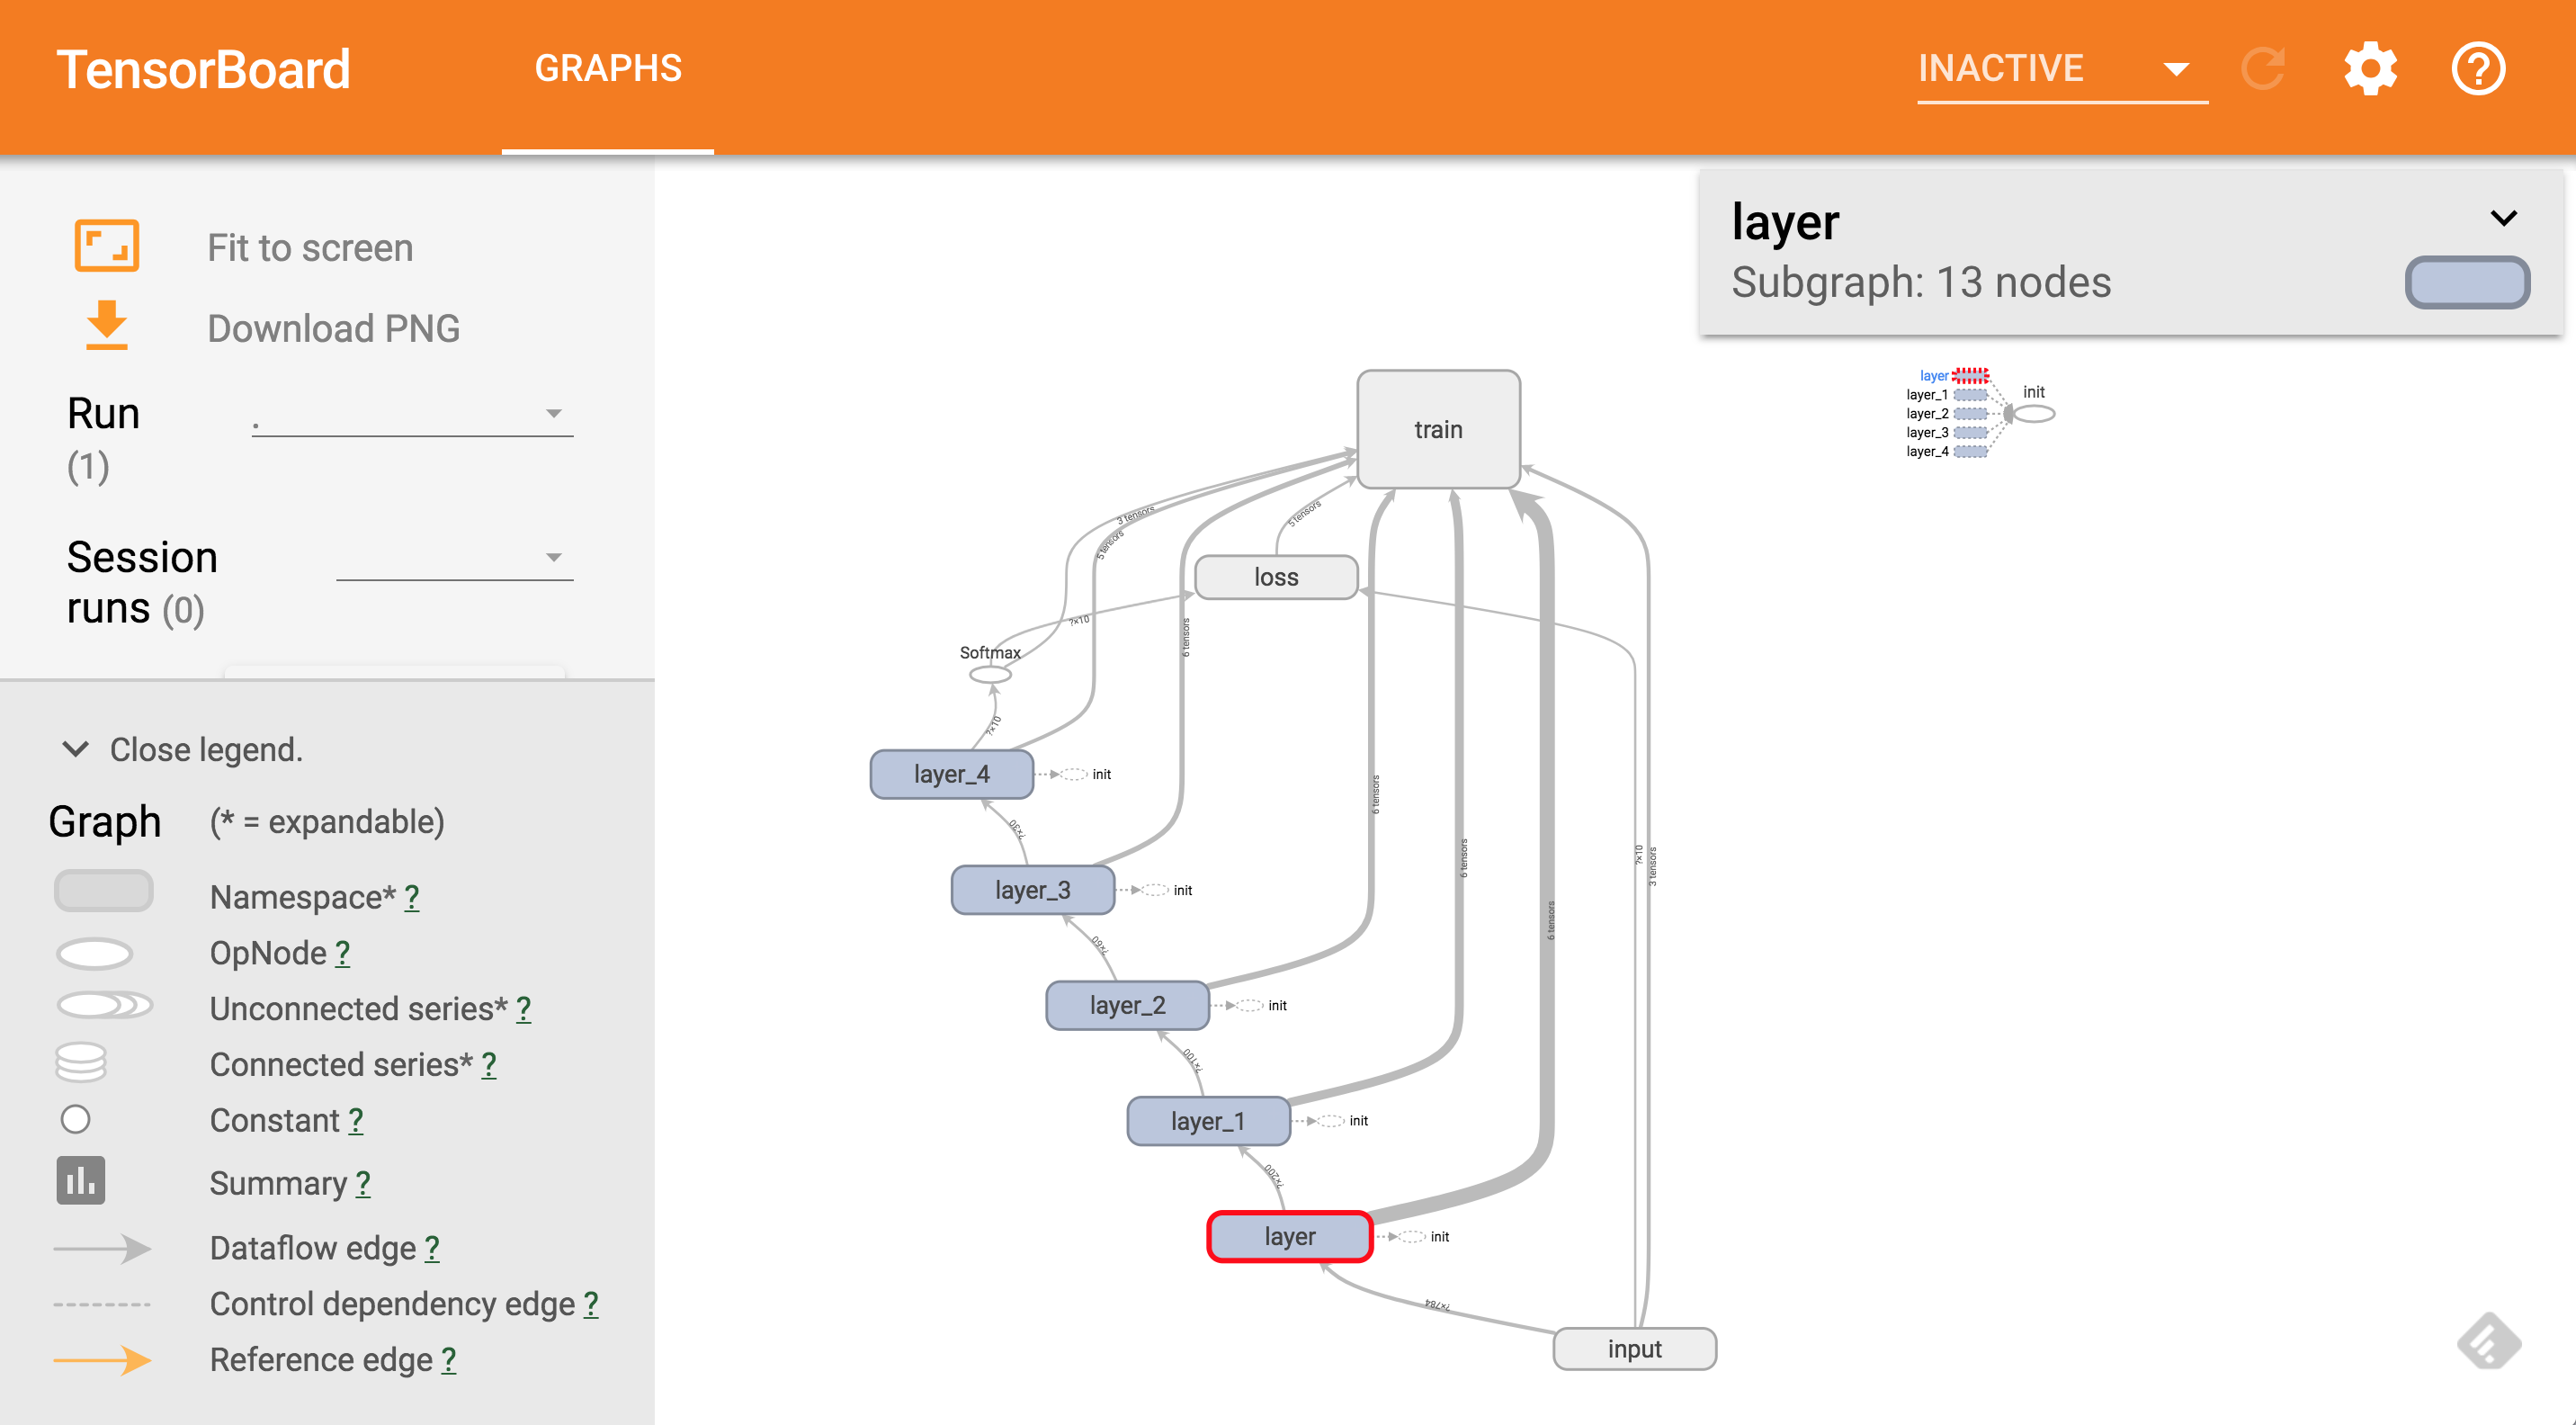

In [8]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# 导入数据
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

with tf.Graph().as_default() as g:
    with tf.name_scope('input'):
        # X: 输入
        X = tf.placeholder(tf.float32, [None, 784], name="X")
        # Y_: 标签
        Y_ = tf.placeholder(tf.float32, [None, 10])

    # L1：200个神经元
    Y1 = add_layer(X, 784, 200, tf.nn.sigmoid)

    # L2：100个神经元
    Y2 = add_layer(Y1, 200, 100, tf.nn.sigmoid)

    # L3: 60个神经元
    Y3 = add_layer(Y2, 100, 60, tf.nn.sigmoid)

    # L4: 30个神经元
    Y4 = add_layer(Y3, 60, 30, tf.nn.sigmoid)

    # L5: 10个神经元
    Ylogits = add_layer(Y4, 30, 10, tf.nn.sigmoid)

    # Output
    Y = tf.nn.softmax(Ylogits)

    # 损失函数
    with tf.name_scope('loss'):
        cross_entropy = tf.reduce_mean(-tf.reduce_sum(Y_ * tf.log(Y), reduction_indices=[1]))
    tf.summary.scalar('cross_entropy', cross_entropy)

    # 优化算法
    with tf.name_scope('train'):
        train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

    merged = tf.summary.merge_all()
    
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        # 将当前会话中的计算图保存
        writer = tf.summary.FileWriter("logs/", sess.graph)

        for i in range(1000):
            batch_xs, batch_ys = mnist.train.next_batch(100)
            summary, _ = sess.run([merged, train_step], feed_dict={X: batch_xs, Y_: batch_ys})
            writer.add_summary(summary, i)

            if i%100 == 0:
                # 计算准确率
                with tf.name_scope('accuracy'):
                    correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
                    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

                print(accuracy.eval({X: mnist.test.images, Y_: mnist.test.labels}))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
0.0754
0.26
0.3271
0.3906
0.4468
0.5263
0.5718
0.607
0.6314
0.648


# 3 TensorFlow概念回顾

您可以将 TensorFlow Core 程序看作由两个互相独立的部分组成：
- 构建计算图 (tf.Graph)
- 运行计算图 (tf.Session)

创建的所有`tf.Operation`和`tf.Tensor`都属于默认的计算图。可以使用`tf.Graph()`创建新的计算图，详细参考：https://www.tensorflow.org/programmers_guide/graphs?hl=zh-cn

## 3.2  变量和张量

### 3.2.1 初始化
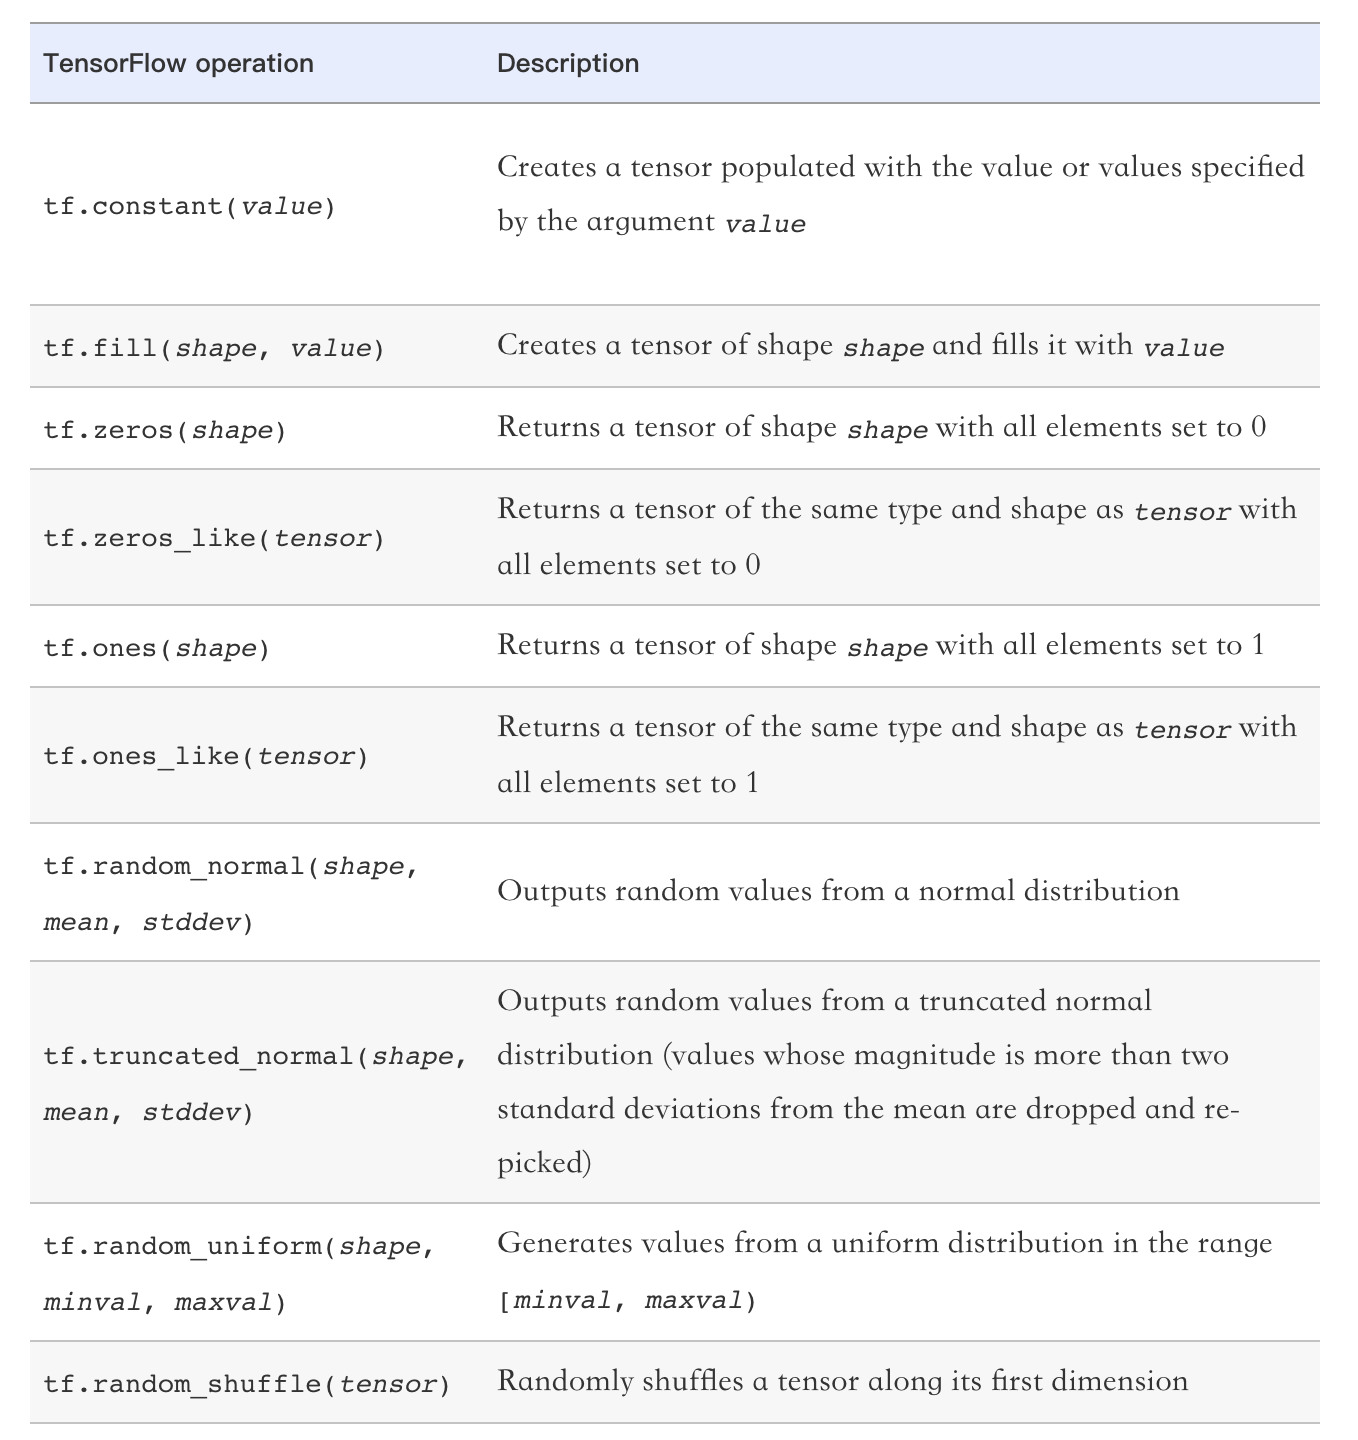

## 3.2.2 变量
TensorFlow 变量是表示程序处理的共享持久状态的最佳方法。

变量通过 tf.Variable 类进行操作。tf.Variable 表示张量，通过运行 op 可以改变它的值。与 tf.Tensor 对象不同，tf.Variable 存在于单个 session.run 调用的上下文之外。

## 3.2.3 变量命名空间

练习：修改`nn_layer`函数，使用`tf.name_scope()`，将所有的变量放置在该层对应名字的命名空间中。

In [22]:
def nn_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.sigmoid):
    '''
    nn_layer
    定义一层神经网络，返回该层的输出。
    ~~~~~~~~~~~~~~~~~~~~~
    input_tensor: 输入
    input_dim: 神经网络上一层的神经元数量
    output_dim: 该层神经元的数量
    layer_name: 名字
    act: 激活函数
    '''
    with tf.name_scope(layer_name):
        weights=tf.Variable(tf.truncated_normal([input_dim, output_dim], stddev=0.1))
        biases=tf.Variable(tf.ones([output_dim]))
        preactivate = tf.matmul(input_tensor, weights)+biases
        activation = act(preactivate)
    
    return activation

练习：修改2.2中MNIST识别的主体代码，将所有变量放入恰当的命名空间中，例如：
- 输入：Input
- 隐藏层：Hidden_Layer
- 损失函数：Loss_Function
- 输出: Output
- 优化算法：Train
- 准确率: Accuracy

In [29]:
# 构建计算图
sess = tf.InteractiveSession()

with tf.name_scope('Input'):
    X = tf.placeholder(tf.float32, [None, 784], name="X")

with tf.name_scope('Hidden_Layer'):
    # L1：200个神经元
    Y1 = nn_layer(X, 784, 200, "L1")

    # L2：100个神经元
    Y2 = nn_layer(Y1, 200, 100, "L2")

    # L3: 60个神经元
    Y3 = nn_layer(Y2, 100, 60, "L3")

    # L4: 30个神经元
    Y4 = nn_layer(Y3, 60, 30, "L4")

    # L5: 10个神经元
    Ylogits = nn_layer(Y4, 30, 10, "L5")

# Output
with tf.name_scope('Output'):
    Y = tf.nn.softmax(Ylogits)

# Y_: 标签
with tf.name_scope('Label'):
    Y_ = tf.placeholder(tf.float32, [None, 10])

# 损失函数
with tf.name_scope('Loss_Function'):
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(Y_ * tf.log(Y), reduction_indices=[1]))

# 优化算法
with tf.name_scope('Train'):
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)


tf.global_variables_initializer().run()

for i in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    _ = sess.run([train_step], feed_dict={X: batch_xs, Y_: batch_ys})

    if i%100 == 0:
        # 计算准确率
        with tf.name_scope('Accuracy'):
            correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
        print(accuracy.eval({X: mnist.test.images, Y_: mnist.test.labels}))
        
sess.close()

/Users/lyon/.pyenv/versions/3.6.4/envs/scikit-learn/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


0.1135
0.1135
0.1135
0.1135
0.1135
0.1135
0.1135
0.1135
0.1135
0.1135


## 4.2 小试牛刀

TensorBoard通过读取TensorFlow的事件文件来运行。TensorFlow 的事件文件包含运行TensorFlow时生成的总结数据。下面是TensorBoard中总结数据的一般生命周期。

首先，创建您想从中收集总结数据的TensorFlow图，然后再选择您想在哪个节点标注[tf.Summary](https://www.tensorflow.org/api_guides/python/summary?hl=zh-cn)指令。

比如，假设您正在训练一个前馈神经网络(FFNN)，用于识别 MNIST 数据。您可能希望记录随着时间的推移，学习速度如何变化，以及目标函数如何变化。通过向节点附加`tf.summary.scalar` op来分别输出学习速度和误差。然后您可以给每个scalar_summary分配一个有意义的tag，如'learning rate'或'loss function'。

或者您还希望显示一个特殊层中激活的分布，或者梯度分布或权重分布。可以通过分别向梯度输出和权重变量附加 tf.summary.histogram op 来收集此数据。

有关所有可用的总结指令的详细信息，可查看总结指令文档。

然后您可以执行该合并的总结 op，它会在特定步骤将所有总结数据生成一个序列化的Summary protobuf对象。最后，如要将此总结数据写入磁盘，请将此总结protobuf对象传递给 tf.summary.FileWriter。

详细介绍参考：https://www.tensorflow.org/programmers_guide/summaries_and_tensorboard?hl=zh-cn

```
# 增加损失函数事件
tf.summary.scalar('cross_entropy', cross_entropy)

# FileWriter
train_writer = tf.summary.FileWriter('./train')

# 运行时，增加事件
train_writer.add_summary(summary, i)
```

## 4.3 查看损失函数

练习：基于3.2.3的程序，增加损失函数的事件，通过TensorBoard查看迭代过程中的值。

In [16]:
# 构建计算图
sess = tf.InteractiveSession()

X = tf.placeholder(tf.float32, [None, 784], name="X")

# L1：200个神经元
W1 = tf.Variable(tf.truncated_normal([784, 200], stddev=0.1))
B1 = tf.Variable(tf.zeros([200]))
Y1 = tf.nn.sigmoid(tf.matmul(X, W1)+B1)

# L2：100个神经元
W2 = tf.Variable(tf.truncated_normal([200, 100], stddev=0.1))
B2 = tf.Variable(tf.zeros([100]))
Y2 = tf.nn.sigmoid(tf.matmul(Y1, W2)+B2)

# L3: 60个神经元
W3 = tf.Variable(tf.truncated_normal([100, 60], stddev=0.1))
B3 = tf.Variable(tf.zeros([60]))
Y3 = tf.nn.sigmoid(tf.matmul(Y2, W3)+B3)

# L4: 30个神经元
W4 = tf.Variable(tf.truncated_normal([60, 30], stddev=0.1))
B4 = tf.Variable(tf.zeros([30]))
Y4 = tf.nn.sigmoid(tf.matmul(Y3, W4)+B4)

# L5: 10个神经元
W5 = tf.Variable(tf.truncated_normal([30, 10], stddev=0.1))
B5 = tf.Variable(tf.ones([10]))
Ylogits = tf.matmul(Y4, W5) + B5

# Output
Y = tf.nn.softmax(Ylogits)

# Y_: 标签
Y_ = tf.placeholder(tf.float32, [None, 10])

# 损失函数
cross_entropy = tf.reduce_mean(-tf.reduce_sum(Y_ * tf.log(Y), reduction_indices=[1]))
tf.summary.scalar('cross_entropy', cross_entropy)

# 优化算法
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter('./train')

tf.global_variables_initializer().run()

for i in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    summary, _ = sess.run([merged, train_step], feed_dict={X: batch_xs, Y_: batch_ys})
    train_writer.add_summary(summary, i)

    if i%100 == 0:
        # 计算准确率
        correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        print(accuracy.eval({X: mnist.test.images, Y_: mnist.test.labels}))
        
sess.close()

InvalidArgumentError: You must feed a value for placeholder tensor 'X' with dtype float and shape [?,784]
	 [[Node: X = Placeholder[dtype=DT_FLOAT, shape=[?,784], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'X', defined at:
  File "/Users/lyon/.pyenv/versions/3.6.4/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/lyon/.pyenv/versions/3.6.4/Python.framework/Versions/3.6/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/lyon/.pyenv/versions/3.6.4/envs/scikit-learn/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/lyon/.pyenv/versions/3.6.4/envs/scikit-learn/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/lyon/.pyenv/versions/3.6.4/envs/scikit-learn/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/Users/lyon/.pyenv/versions/3.6.4/envs/scikit-learn/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/lyon/.pyenv/versions/3.6.4/envs/scikit-learn/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/lyon/.pyenv/versions/3.6.4/envs/scikit-learn/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/Users/lyon/.pyenv/versions/3.6.4/envs/scikit-learn/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/lyon/.pyenv/versions/3.6.4/envs/scikit-learn/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/Users/lyon/.pyenv/versions/3.6.4/envs/scikit-learn/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/lyon/.pyenv/versions/3.6.4/envs/scikit-learn/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/lyon/.pyenv/versions/3.6.4/envs/scikit-learn/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/lyon/.pyenv/versions/3.6.4/envs/scikit-learn/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/lyon/.pyenv/versions/3.6.4/envs/scikit-learn/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/lyon/.pyenv/versions/3.6.4/envs/scikit-learn/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/lyon/.pyenv/versions/3.6.4/envs/scikit-learn/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/lyon/.pyenv/versions/3.6.4/envs/scikit-learn/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/lyon/.pyenv/versions/3.6.4/envs/scikit-learn/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-54ef8cad16e5>", line 4, in <module>
    X = tf.placeholder(tf.float32, [None, 784], name="X")
  File "/Users/lyon/.pyenv/versions/3.6.4/envs/scikit-learn/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1808, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/Users/lyon/.pyenv/versions/3.6.4/envs/scikit-learn/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 4848, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/Users/lyon/.pyenv/versions/3.6.4/envs/scikit-learn/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/lyon/.pyenv/versions/3.6.4/envs/scikit-learn/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3392, in create_op
    op_def=op_def)
  File "/Users/lyon/.pyenv/versions/3.6.4/envs/scikit-learn/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1718, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'X' with dtype float and shape [?,784]
	 [[Node: X = Placeholder[dtype=DT_FLOAT, shape=[?,784], _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


产生的数据在当前路径的`train`目录下。

## 4.3 重构

重复运行上述代码报错，主要问题出在`merged = tf.summary.merge_all()`具有记忆性。需要：
1. 创建新的计算图，并将其作为默认图。`with tf.Graph().as_default() as g:"
2. 不使用`tf.InteractiveSession()`，改用`with tf.Session() as sess:`
练习：根据上述两点，重构3.2.3的代码，并增加4.2中关于TensorBoard的代码；

In [ ]:
# 代码......

# 5 优化

In [17]:
def nn_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.sigmoid):
    '''
    nn_layer
    定义一层神经网络，返回该层的输出。
    ~~~~~~~~~~~~~~~~~~~~~
    input_tensor: 输入
    input_dim: 神经网络上一层的神经元数量
    output_dim: 该层神经元的数量
    layer_name: 名字
    act: 激活函数
    '''
    with tf.name_scope(layer_name):
        weights=tf.Variable(tf.truncated_normal([input_dim, output_dim], stddev=0.1))
        biases=tf.Variable(tf.ones([output_dim]))
        preactivate = tf.matmul(input_tensor, weights)+biases
        activation = act(preactivate)
    
    return activation

# 构建计算图
with tf.Graph().as_default() as g:
    with tf.name_scope('Input'):
        X = tf.placeholder(tf.float32, [None, 784], name="X")

    with tf.name_scope('Hidden_Layer'):
        # L1：200个神经元
        Y1 = nn_layer(X, 784, 200, "L1")

        # L2：100个神经元
        Y2 = nn_layer(Y1, 200, 100, "L2")

        # L3: 60个神经元
        Y3 = nn_layer(Y2, 100, 60, "L3")

        # L4: 30个神经元
        Y4 = nn_layer(Y3, 60, 30, "L4")

        # L5: 10个神经元
        Ylogits = nn_layer(Y4, 30, 10, "L5")

    # Output
    with tf.name_scope('Output'):
        Y = tf.nn.softmax(Ylogits)

    # Y_: 标签
    with tf.name_scope('Label'):
        Y_ = tf.placeholder(tf.float32, [None, 10])

    # 损失函数
    with tf.name_scope('Loss_Function'):
        cross_entropy = tf.reduce_mean(-tf.reduce_sum(Y_ * tf.log(Y), reduction_indices=[1]))

    tf.summary.scalar('cross_entropy', cross_entropy)
    
    # 优化算法
    with tf.name_scope('Train'):
        train_step = tf.train.GradientDescentOptimizer(0.1).minimize(cross_entropy)
        #train_step = tf.train.AdamOptimizer(0.003).minimize(cross_entropy)

    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter('./train')

    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        
        for i in range(1000):
            batch_xs, batch_ys = mnist.train.next_batch(100)
            summary, loss,  _ = sess.run([merged, cross_entropy, train_step], feed_dict={X: batch_xs, Y_: batch_ys})
            train_writer.add_summary(summary, i)
            #print("loss: {0}".format(loss))


            if i%100 == 0:
                # 计算准确率
                with tf.name_scope('Accuracy'):
                    correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
                    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

                print(accuracy.eval({X: mnist.test.images, Y_: mnist.test.labels}))

0.101
0.101
0.101
0.101
0.1135
0.1135
0.1135
0.1135
0.1135
0.1135


# 参考
1. https://morvanzhou.github.io/tutorials/machine-learning/tensorflow/4-1-tensorboard1/